# Exploratory Data Analysis on Playstation Game Metadata



In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances
from sklearn.feature_selection.variance_threshold import VarianceThreshold
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from collections import Counter

# Content: 

Import Game Meta Data

In [2]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./GB_API_Scrape//game_meta_data/') if isfile(join('./GB_API_Scrape//game_meta_data/', f))] #get list of files
list_of_meta = [] # fill this list with dictionaries 
feature_list = ['guid', 'name', 'concepts', 'themes', 'deck', 'developers', 'publishers', 'genres'] #list of features I care about
for file in onlyfiles:
    #looping through files, open them, put their contents into a dict, and add it to the list
    with open(f'./GB_API_Scrape//game_meta_data/{file}', 'r') as f:
        game = json.load(f)
        game_dict = {key:value for key, value in game.items() if key in feature_list}

        # convert lists to strings 
        for key, value in game_dict.items():
            if type(value) == list:
                game_dict[key] = ', '.join(value)
        list_of_meta.append(game_dict)
# make pandas dataframe
df = pd.DataFrame(list_of_meta)
df.fillna("", inplace=True)

## Here we have the raw data frame.  We need to:
* Dummy the columns 
* Drop features that are too sparse
* Drop games that have too few features

In [3]:
df.head()

,concepts,deck,developers,genres,guid,name,publishers,themes
0,"Achievements, PlayStation Trophies, Steam, Dig...",Kill The Bad Guy is a puzzle-game where physic...,Exkee,"Strategy, Simulation",3030-46539,Kill the Bad Guy,,
1,,Zeal is an indie online ARPG developed by Lyca...,Lycanic Studios,"Action, Role-Playing, MOBA",3030-68714,Zeal,,"Fantasy, Medieval"
2,,Vertical Drop Heroes HD is an action platformer.,Nerdook Productions,"Action, Role-Playing, Platformer",3030-48249,Vertical Drop Heroes HD,,Fantasy
3,"Unreal Engine 4, PlayStation VR Support",A puzzle mystery game for PS VR.,Tarsier Studios,Puzzle,3030-57976,Statik,,
4,,A compilation of all three Banner Saga titles.,Stoic,"Strategy, Role-Playing, Compilation",3030-68731,The Banner Saga Trilogy,,Fantasy


In [4]:
def split_features_from_col(df, col):
    '''
    Returns a dataframe of 1 hot encoded features from the selected col 
    '''
    df[col] = ['' if entry == None else entry for entry in df[col] ]
    cvec = CountVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
    bow = cvec.fit_transform(df[col])
    ret_df  = pd.DataFrame(bow.todense(),
                       columns=map(lambda x: col + "_" + x, cvec.get_feature_names()))
    ret_df.drop(col+'_', 1, inplace=True)
    return ret_df

def split_features(df, list_of_cols):
    '''
    Returns a dataframe of 1 hot encoded features from a list of cols
    '''
    ret_df = df.loc[:, ['name', 'guid']]
    for col in list_of_cols:
        ret_df = pd.merge(ret_df, split_features_from_col(df, col), left_index=True, right_index=True)
        
    return ret_df

In [5]:
# We have 4 features that we want to split
dummied_df = split_features(df, ['concepts', 'genres', 'themes', 'developers'])

In [6]:
dummied_df.set_index("name", inplace=True)

In [7]:
dummied_df.drop("guid", 1, inplace=True)

In [8]:
dummied_df.shape

(1746, 5070)

##  Manual Feature Reduction

In [9]:
dummied_df.var().sort_values(ascending=False)[0:20]

concepts_digital distribution    0.236484
concepts_steam                   0.193403
themes_fantasy                   0.171660
genres_action                    0.169722
themes_sci-fi                    0.154435
concepts_indie                   0.128014
concepts_steam achievements      0.127613
genres_adventure                 0.114020
genres_role-playing              0.111472
concepts_achievements            0.108037
genres_platformer                0.104998
genres_action-adventure          0.104123
concepts_playstation trophies    0.102367
concepts_steam trading cards     0.100156
concepts_gog.com                 0.097034
concepts_2d                      0.093879
concepts_voice acting            0.090693
themes_comedy                    0.088397
concepts_male protagonists       0.084689
genres_puzzle                    0.081881
dtype: float64

### I don't want features like `concepts_digital distribution` or any tradeshow data like `concepts_e3` or `concepts_pax`.  I also don't care about achievements

In [10]:
drop_cols = ["concepts_digital distribution", "concepts_wasd movement", 
             "concepts_achievements", "concepts_playstation trophies",
              "concepts_subtitles"]
for col in dummied_df.columns:
    if ("concepts_steam" in col) or ("concepts_pax" in col) or ("concepts_e3" in col):
        drop_cols.append(col)
drop_cols[0:10]
print(f"Dropping {len(drop_cols)} columns")

Dropping 58 columns


In [11]:
dummied_df.drop(drop_cols, 1, inplace=True)

### Dropping games with too few (5 or less) features
Games that don't have many features will not be similar to any other games

In [12]:
thresh = 6
(dummied_df.iloc[:,2:].T.sum()>=thresh).sum()

1073

In [13]:
dummied_df.drop(dummied_df[dummied_df.iloc[:,2:].T.sum()<thresh].index, 0, inplace=True)

In [14]:
dummied_df.shape

(1073, 5012)

## Using Sklearn's Variance Threshold to drop features with variance of .005 and less

In [15]:
vt = VarianceThreshold(.005)
thresh_matrix = vt.fit_transform(dummied_df)

In [16]:
thresh_matrix.shape

(1073, 1208)

In [17]:
thresh_df = pd.DataFrame(thresh_matrix, columns=dummied_df.columns[vt.get_support(indices=True)], index=dummied_df.index)

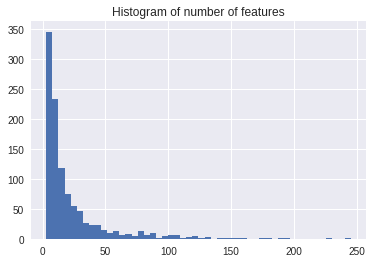

In [57]:
plt.hist(np.sum(thresh_matrix, 1), bins=50)
plt.title("Histogram of number of features");
# plt.savefig("figures/num_feats.png")

## Let's look at some Venn Diagrams

In [19]:
# !pip install matplotlib-venn
from matplotlib_venn import venn2

In [54]:
def search_game(search): # Added to class
    '''
    This helper function looks for games that match the search and returns them as a list
    '''
    ret = [game for game in thresh_df.index if search.strip().lower() in game.lower() ]
    if ret !=[]:
        return ret[0]
    else: 
        return None

def makeVenn(game1, game2, savefig=False, name = ""):
    game1 = search_game(game1)
    game2 = search_game(game2)
    if game1 and game2:
        g1_feats = thresh_df.loc[game1, thresh_df.loc[game1, :] ==1].index
        g2_feats = thresh_df.loc[game2, thresh_df.loc[game2, :] ==1].index
        venn2([set(g1_feats), set(g2_feats)], [game1, game2])
        if savefig:
            with open(f"figures/venn_{name}.png", "wb+") as f:
                plt.savefig(f)

### 2 Related Games

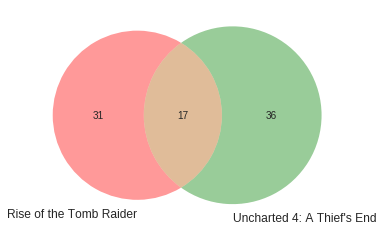

In [55]:
makeVenn("Tomb Raider", "Uncharted 4 ", savefig=True, name="TombRaider_Uncharted4")

### 2 Unrelated Games

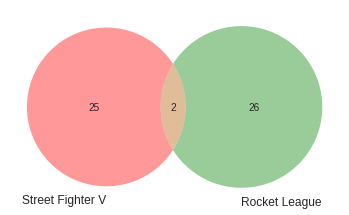

In [56]:
makeVenn("Street Fighter V", "Rocket League", savefig=True, name="StreetFighterV_RocketLeague")

## Using TruncatedSVD to reduce feature space
* The goal was to capture at least 90% of the variance
* I found that 300 components does this

In [23]:
svd = TruncatedSVD(300)
content = svd.fit_transform(thresh_matrix)

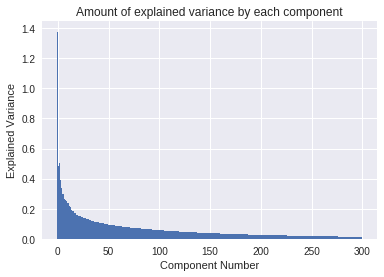

In [59]:
plt.bar(range(svd.n_components),svd.explained_variance_, width = 1)
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.title("Amount of explained variance by each component");
# plt.savefig("figures/variance_per_component.png")

300 components captures 90.42675354464724% of variance


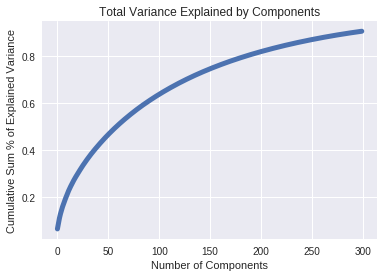

In [60]:
print(f"{svd.n_components} components captures {100*svd.explained_variance_ratio_.sum()}% of variance")
plt.plot(range(svd.n_components), np.cumsum(svd.explained_variance_ratio_), linewidth = 5)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Sum % of Explained Variance")
plt.title("Total Variance Explained by Components");
# plt.savefig("figures/total_variance.png")

In [26]:
component_mapping = pd.DataFrame(svd.components_, columns=thresh_df.columns)

### Here are some of the feature loadings for a few components.  


In [27]:
for i in [0, 1, 2, 4, 5, 6, ]:
    for feat in component_mapping.loc[i, :].sort_values(ascending=False)[0:5].index:
        print(feat)
    print()

concepts_voice acting
concepts_male protagonists
concepts_polygonal 3d
themes_fantasy
concepts_health

concepts_profanity
concepts_blood
concepts_real-time combat
concepts_third-person perspective
concepts_mercenary

genres_adventure
concepts_gog.com
concepts_puzzles
concepts_confirm menu choices
concepts_indie

concepts_boss fight
concepts_bosses
concepts_health
concepts_death
concepts_melee

genres_platformer
genres_action-adventure
concepts_jump
themes_fantasy
concepts_collectibles

concepts_explosion
concepts_leveling up
themes_sci-fi
concepts_heads up display
concepts_upgradeable weapons



#### Each of these components remind me of games I have played:
* Skyrim
* Fortnite
* Fez
* Dark Souls
* Ori and the Blind Forest
* Mass Effect.  